#### **Cовместная фильтрация**
Тип системы рекомендаций, где характеристики пользователя (например, возраст, пол) или элемент (например, скоропортяющийся или нет) не играют никакой роли в алгоритме. Вместо этого мы полагаемся исключительно на рейтинги, которые пользователь дал товару. 

Cосредоточимся на моделях совместной фильтрации, которые, как правило, можно разделить на два класса: совместная фильтрация на основе пользователей и элементов. **В любом сценарии строится матрица сходства.** Для совместной фильтрации на основе пользователей матрица пользовательского сходства будет состоять из некоторой метрики расстояния, которая измеряет сходство между любыми двумя парами пользователей. Аналогичным образом, матрица сходства элементов будет измерять сходство между любыми двумя парами элементов.

In [51]:
# испортируем библиотеки

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from subprocess import call
from sklearn.metrics import mean_squared_error

In [52]:
# импортируем данные, с которыми предстоит работа

names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep = '\t', names = names)

print('Размер выборки:', df.shape)
df.head()

Размер выборки: (100000, 4)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Большинство рекомендательных моделей состоят из создания матрицы пользователя по элементам с каким-то номером "взаимодействия" в каждой ячейке. Если включить числовые рейтинги, которые пользователи дают, то это называется **моделью явной обратной связи**. В качестве альтернативы можно включить неявную обратную связь, которая является действиями пользователя, которые означают положительное или отрицательное предпочтение для данного элемента (например, просмотр товара онлайн). К этим двум сценариям часто нужно относиться по-разному.

В случае набора данных MovieLens **у нас есть рейтинги, поэтому мы сосредоточимся на моделях явной обратной связи**. Во-первых, мы должны построить нашу матрицу пользовательских элементов. Мы можем легко сопоставить идентификаторы пользователей/предметов с индексами пользователей/предметов, удалив смещение "Python начинается с 0" между ними.

In [53]:
# построение матрицы пользовательского элемента

n_users = df['user_id'].unique().shape[0] # 943 уникальных пользователя
n_items = df['item_id'].unique().shape[0] # 1682 уникальных предмета

ratings = np.zeros((n_users, n_items))
for row in df.itertuples(index = False): # перебор строк, как именованные кортежи
    ratings[row.user_id - 1, row.item_id - 1] = row.rating

In [54]:
matrix_size = np.prod(ratings.shape) # произведение элементов числовой последовательности
interaction = np.flatnonzero(ratings).shape[0] # массив ненулевых индексов в массиве
sparsity = 100 * (interaction / matrix_size) # в рейтинговой матрице только 6,3% ячеек имеют значение

print('dimension: ', ratings.shape)
print('sparsity: {:.1f}%'.format(sparsity))
ratings

dimension:  (943, 1682)
sparsity: 6.3%


array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

Это означает, что 6,3% рейтингов пользовательских товаров имеют ценность. 

Обратите внимание, что, хотя мы заполнили отсутствующие рейтинги как 0, мы не должны предполагать, что эти значения действительно равны нулю. Более уместно, это просто пустые записи. Мы разделим наши данные на учебные и тестовые наборы, удалив 10 оценок на пользователя из тренировочного набора и поместив их в тестовый набор.

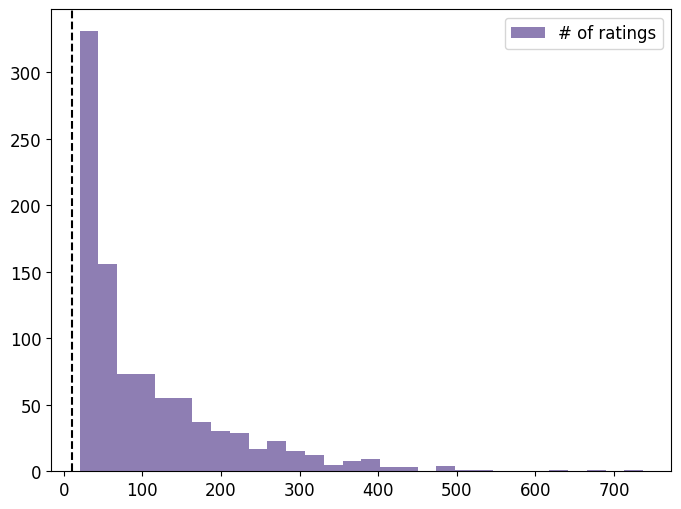

In [55]:
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

plt.hist(np.sum(ratings != 0, axis = 1), histtype = 'stepfilled', bins = 30,
         alpha = 0.85, label = '# of ratings', color = '#7A68A6')
plt.axvline(x = 10, color = 'black', linestyle = '--')
plt.legend(loc = "upper right")
plt.show()

In [56]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [57]:
train, test = train_test_split(ratings)

**Общая метрика расстояния** - это сходство косинусов. Метрику можно продумать геометрически, если относиться к строке (колонке) данного пользователя (элемета) матрицы оценок в качестве вектора. Для совместной фильтрации на основе пользователей сходство двух пользователей измеряется как косинус угла между векторами двух пользователей

In [58]:
def slow_similarity(ratings, kind='user'):
    if kind == 'user':
        axmax = 0
        axmin = 1
    elif kind == 'item':
        axmax = 1
        axmin = 0
    sim = np.zeros((ratings.shape[axmax], ratings.shape[axmax]))
    for u in range(ratings.shape[axmax]):
        for uprime in range(ratings.shape[axmax]):
            rui_sqrd = 0.
            ruprimei_sqrd = 0.
            for i in range(ratings.shape[axmin]):
                sim[u, uprime] = ratings[u, i] * ratings[uprime, i]
                rui_sqrd += ratings[u, i] ** 2
                ruprimei_sqrd += ratings[uprime, i] ** 2
            sim[u, uprime] /= rui_sqrd * ruprimei_sqrd
    return sim

def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [59]:
%timeit fast_similarity(train, kind='user')

21 ms ± 996 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [60]:
user_similarity = fast_similarity(train, kind='user')
item_similarity = fast_similarity(train, kind='item')
print(item_similarity[:4, :4])

[[1.         0.40971221 0.31447771 0.46352396]
 [0.40971221 1.         0.26350835 0.48318333]
 [0.31447771 0.26350835 1.         0.34226152]
 [0.46352396 0.48318333 0.34226152 1.        ]]


Имея в руках нашу матрицу сходства, мы теперь можем предсказать рейтинги, которые не были включены в данные. Используя эти прогнозы, мы можем сравнить их с тестовыми данными, чтобы попытаться проверить качество нашей рекомендательной модели.

Для пользовательской совместной фильтрации мы прогнозируем, что пользовательский рейтинг для товара задается взвешенной суммой оценок всех других пользователей для товара, где взвешивание - это косинус сходство между каждым пользователем и пользователем ввода.

In [61]:
def predict_slow_simple(ratings, similarity, kind='user'):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :].dot(ratings[:, j])\
                             /np.sum(np.abs(similarity[i, :]))
        return pred
    elif kind == 'item':
        for i in range(ratings.shape[0]):
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[j, :].dot(ratings[i, :].T)\
                             /np.sum(np.abs(similarity[j, :]))

        return pred

def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

Мы будем использовать функцию ошибки в квадрате scikit-learn в качестве нашей метрики проверки. Сравнивая совместную фильтрацию на основе пользовательских и элементов, похоже, что совместная фильтрация на основе пользовательских элементов дает нам лучший результат.

In [62]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [63]:
item_prediction = predict_fast_simple(train, item_similarity, kind='item')
user_prediction = predict_fast_simple(train, user_similarity, kind='user')

print('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

User-based CF MSE: 8.369977223408236
Item-based CF MSE: 11.520432052654389


#### Матрица факторизации

Мы будем использовать те же примеры данных из предыдущего примера, поэтому напомните, что у нас была матрица пользователя по элементам, где ненулевые элементы матрицы являются рейтингами, которые пользователь дал элементу. 

Матричная факторизация предполагает, что:

- Каждый пользователь может быть описан k атрибутами или функциями. Например, функция 1 может быть числом, которое говорит о том, насколько каждый пользователь любит научно-фантастические фильмы.
- Каждый элемент (фильм) может быть описан аналогичным набором k атрибутов или функций. Чтобы соответствовать приведенному выше примеру, функция 1 для фильма может быть числом, которое говорит о том, насколько близок фильм к чистой научной фантастике.
- Если мы умножим каждую функцию пользователя на соответствующую функцию фильма и сложим все вместе, это будет хорошим приближением для рейтинга, который пользователь даст этому фильму.

Вот и все. Красота в том, что мы не знаем, что это за черты. Мы также не знаем, сколько (k) функций актуальны. Мы просто выбираем число для k и изучаем соответствующие значения для всех функций для всех пользователей и элементов. Как мы учимся? Конечно, минимизируя функцию потерь!

Мы можем превратить нашу аппроксимацию матричной факторизации пользователя k-атрибута в математику, позволив пользователю принять форму k-мерного вектора. Аналогично, элемент i может быть представлен k-мерным вектором. Прогнозируемый рейтинг Useru для элемента i - это просто тотокное произведение их двух векторов

Чередование наименьших квадратов

Для минимизации ALS мы держим один набор констант скрытых векторов. Для этого примера мы выберем векторы элементов. Затем мы берем производную функции потерь по отношению к другому набору векторов (пользовательские векторы). Мы устанавливаем производную равной нулю (мы ищем минимум) и решаем для неконстантных векторов (пользовательские векторы). Теперь приходит чередующееся часть: с этими новыми, решенными для пользователя векторами в руках мы держим их постоянными, вместо этого, и берим производную функции потерь по отношению к ранее постоянным векторам (векторы элемента). Мы чередуем туда-сюда и проводим этот двухступенчатый танец до сближения.

In [64]:
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print('\tcurrent iteration: {}'.format(ctr))
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
    def calculate_learning_curve(self, iter_array, test):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print('Train mse: ' + str(self.train_mse[-1]))
                print('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

Давайте попробуем начальное обучение с 40 скрытыми факторами и без регуляризации. Мы вычислим кривую обучения, отслеживающую MSE в зависимости от итераций обучения, а затем нарисуем результат.

In [65]:
MF_ALS = ExplicitMF(train, n_factors=40, \
                    user_reg=0.0, item_reg=0.0)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test)

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

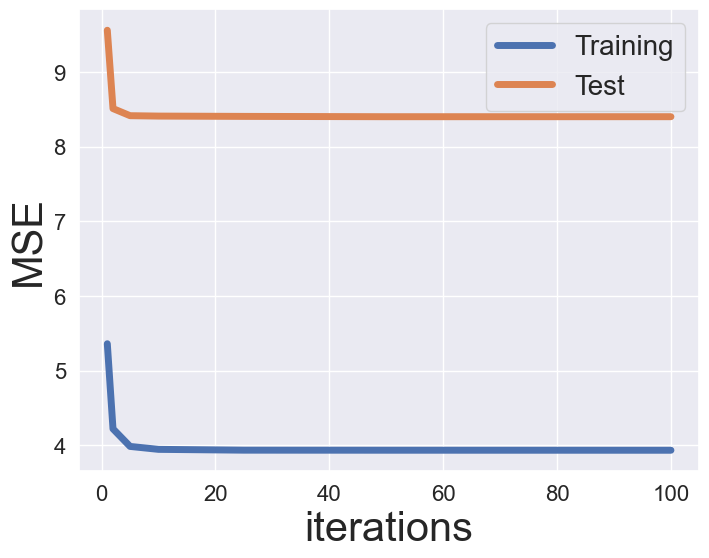

In [67]:
plot_learning_curve(iter_array, MF_ALS)

Для справки: https://www.ethanrosenthal.com/2016/01/09/explicit-matrix-factorization-sgd-als/